In [1]:
import os
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

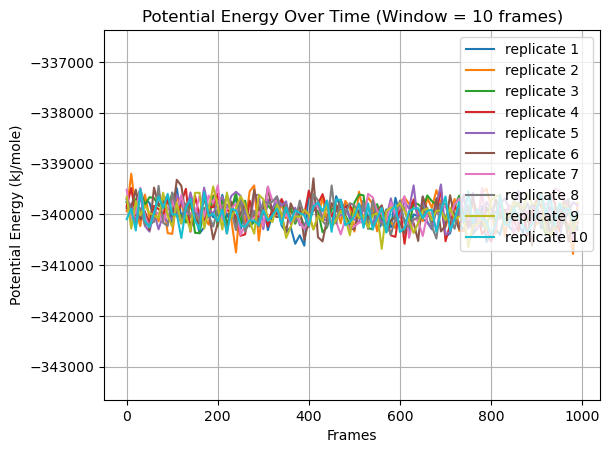

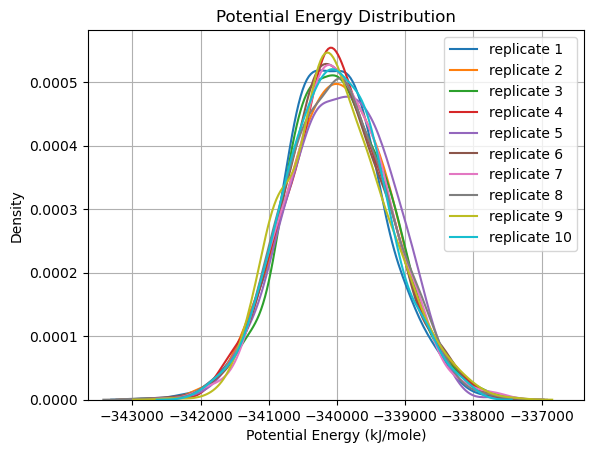

(10, 1000)


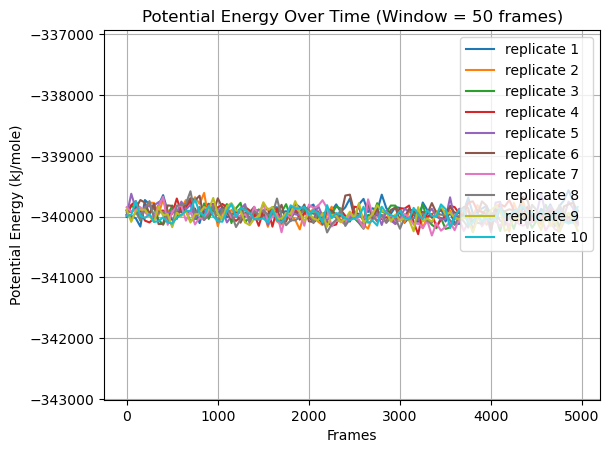

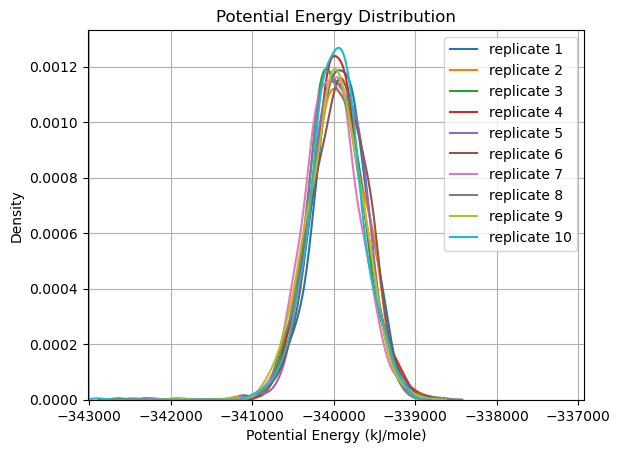

(10, 1000)


In [9]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return energy_arrays

gmx_files = [f'gromacs/replicate_{i}/potential.xvg' for i in range(1, 11)]
gmx_energy_arrays = plot_potential_energy('gromacs', gmx_files, 'line', window=10)
gmx_energy_arrays = plot_potential_energy('gromacs', gmx_files, 'hist', window=1)
print(np.shape(gmx_energy_arrays))
omm_files = [f'openmm/NPT/energy_data_{i}.csv' for i in range(1, 11)]
omm_energy_arrays = plot_potential_energy('openmm', omm_files, 'line', window=50)
omm_energy_arrays = plot_potential_energy('openmm', omm_files, 'hist', window=5)
print(np.shape(omm_energy_arrays))

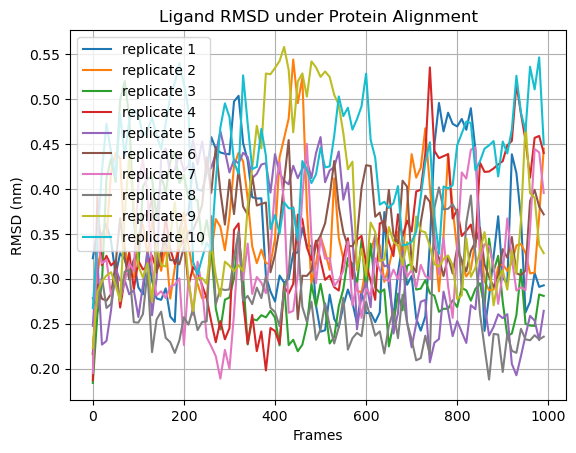

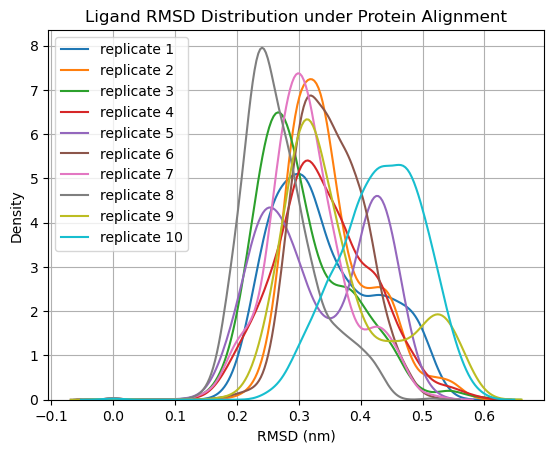

(10, 1001)


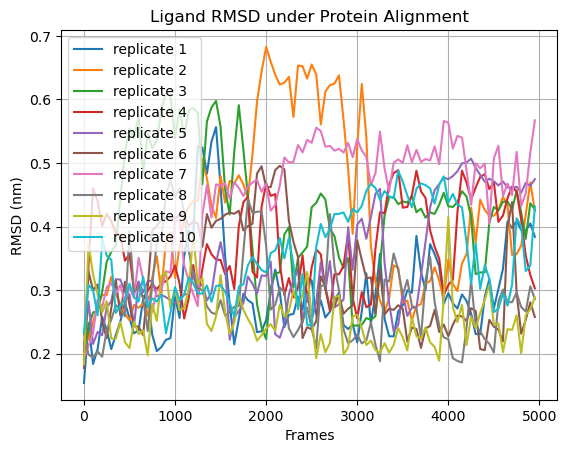

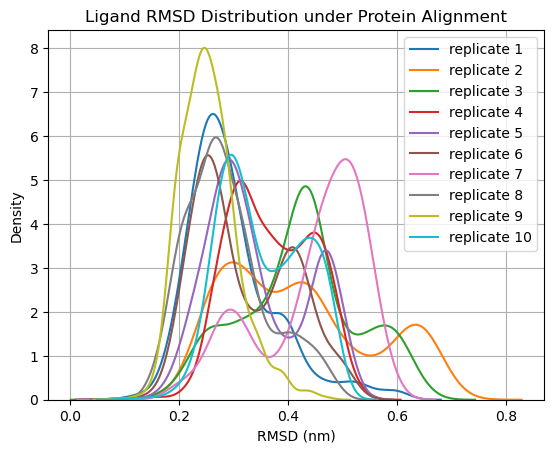

(10, 1000)


In [10]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        traj.image_molecules(inplace=True)
        frames = np.arange(0, traj.n_frames)
        protein_atoms = traj.topology.select('protein and name CA')
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

gmx_files = [f'gromacs/replicate_{i}/md.xtc' for i in range(1, 11)]
gmx_top_file = 'gromacs/min.gro'
gmx_rmsd_arrays = plot_rmsd_fluctuations_multiple(gmx_files, gmx_top_file, 'line', window=10)
gmx_rmsd_arrays = plot_rmsd_fluctuations_multiple(gmx_files, gmx_top_file, 'hist', window=1)
print(np.shape(gmx_rmsd_arrays))
omm_files = [f'openmm/NPT/trajectory_{i}.dcd' for i in range(1, 11)]
omm_top_file = 'openmm/complex_in_solvent.pdb'
omm_rmsd_arrays = plot_rmsd_fluctuations_multiple(omm_files, omm_top_file, 'line', window=50)
omm_rmsd_arrays = plot_rmsd_fluctuations_multiple(omm_files, omm_top_file, 'hist', window=5)
print(np.shape(omm_rmsd_arrays))

In [2]:
gmx_files = [f'gromacs/replicate_{i}/md.xtc' for i in range(1, 11)]
gmx_top_file = 'gromacs/min.gro'

omm_files = [f'openmm/NPT/trajectory_{i}.dcd' for i in range(1, 11)]
omm_top_file = 'openmm/complex_in_solvent.pdb'


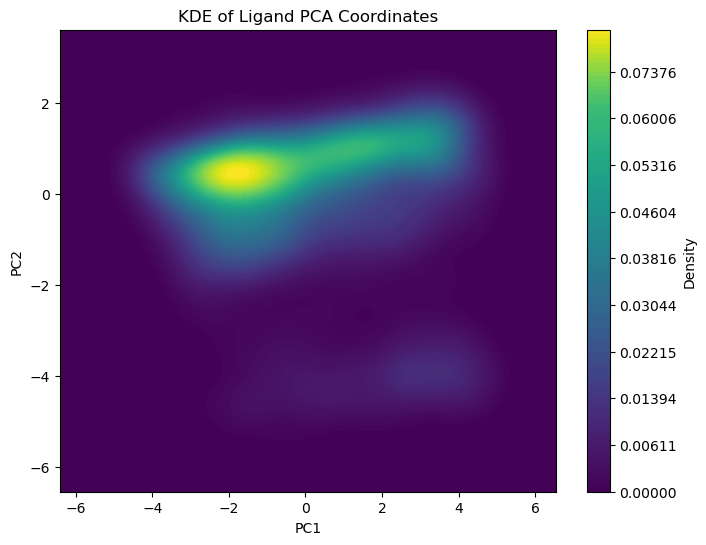

In [3]:
def plot_ligand_pca(traj_files, top_file, slice_step=1):
        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])

        traj_cont.image_molecules(inplace=True)

        protein_atoms = traj_cont.topology.select('protein and name CA')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=protein_atoms)

        ligand_atoms = traj_cont.topology.select('resname UNK')
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

gmx_traj_cont = plot_ligand_pca(gmx_files, gmx_top_file)

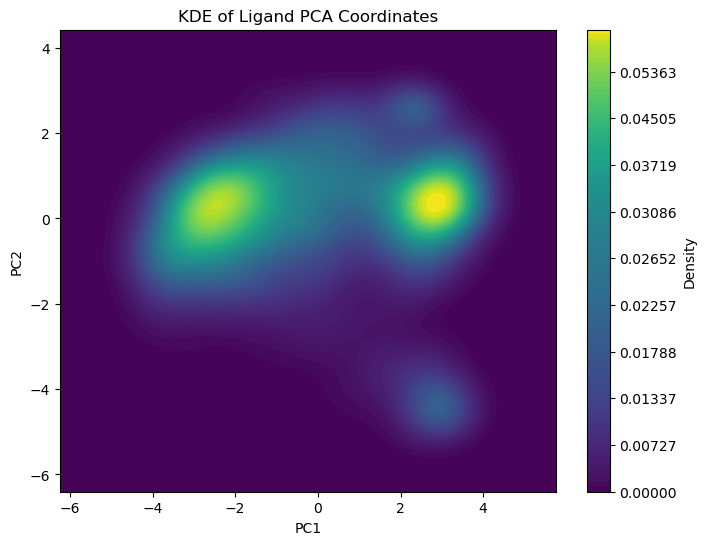

In [4]:
omm_traj_cont = plot_ligand_pca(omm_files, omm_top_file, slice_step=5)

In [ ]:
gmx_traj_cont.save('gromacs/all_processed.xtc')
omm_traj_cont.save('openmm/NPT/all_processed.xtc')

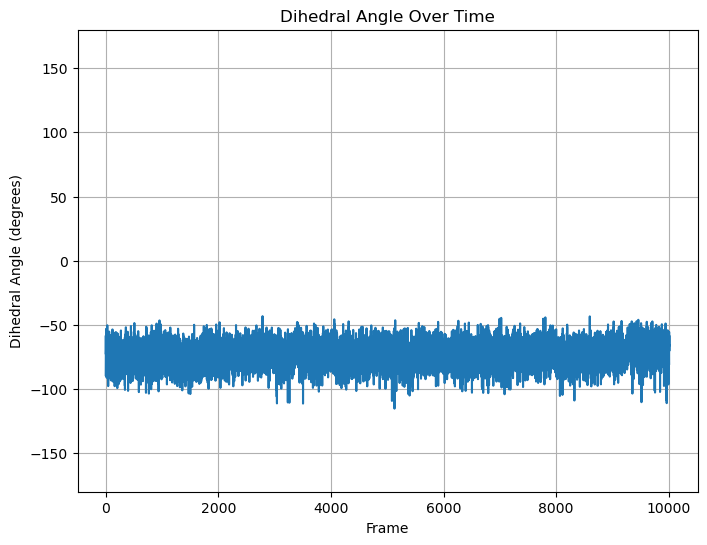

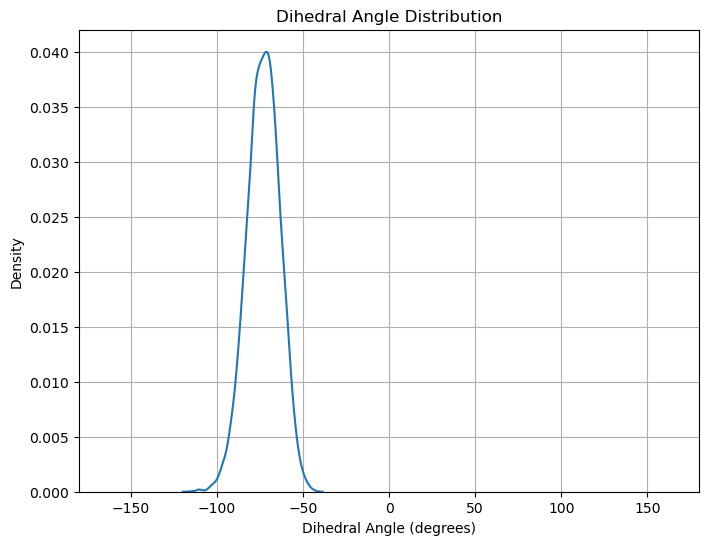

-73.140434


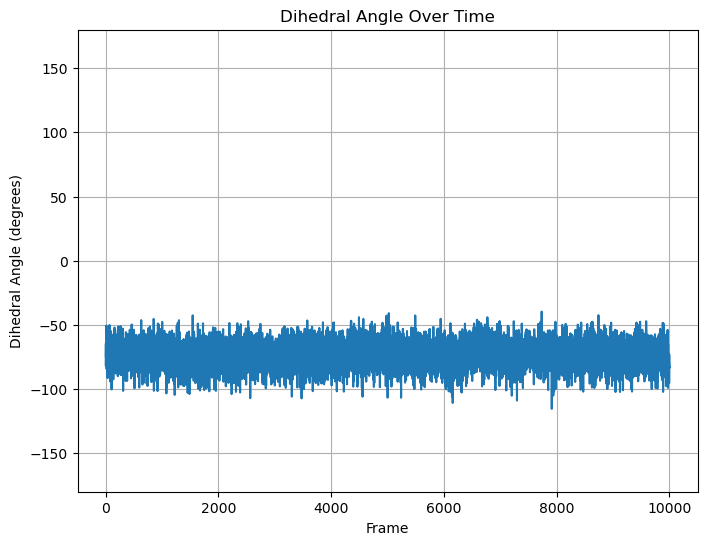

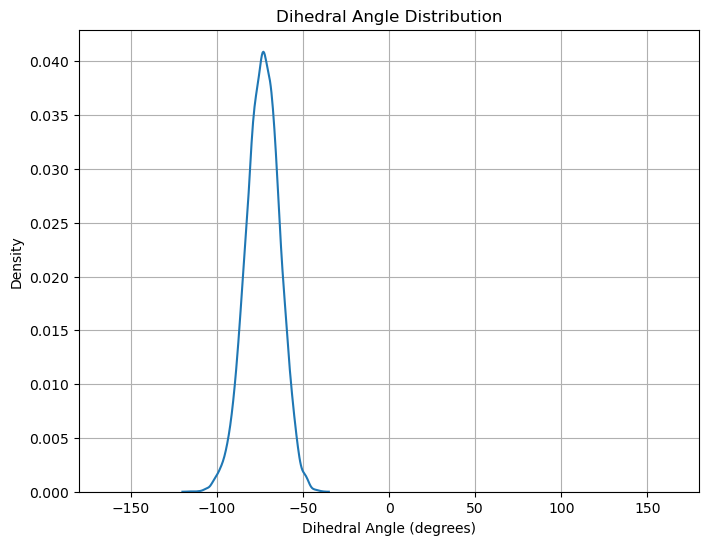

-73.46633


In [8]:
atom_indices = [2510, 2509, 2508, 2503]

def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(dihedral_angles_deg)), dihedral_angles_deg)
    plt.xlabel('Frame')
    plt.ylabel('Dihedral Angle (degrees)')
    plt.title('Dihedral Angle Over Time')
    plt.ylim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

print(plot_dihedral_angles(gmx_traj_cont, atom_indices))
print(plot_dihedral_angles(omm_traj_cont, atom_indices))
